In [ ]:
from google.colab import files
uploaded = files.upload()

Saving blood_donor_dataset.csv to blood_donor_dataset (4).csv


In [ ]:
import pandas as pd
import numpy as np
import io

print("📂 Loading dataset Kaggle...")

# FILE YANG SUDAH DIUPLOAD
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

print(f"Dataset loaded: {len(df)} rows, {len(df.columns)} columns")
print("Kolom yang ada:", list(df.columns))

# ==================== TAMBAH KOLOM BARU ====================
print("\n➕ Adding new columns...")
np.random.seed(42)

# A. Usia (17-65 tahun)
df['usia'] = np.random.randint(17, 66, size=len(df))

# B. Berat Badan (45-100 kg)
df['berat_badan'] = np.random.randint(45, 100, size=len(df))

# C. HB Level (11.0 - 17.0)
df['hb_level'] = np.round(np.random.uniform(11.0, 17.0, size=len(df)), 1)

# D. Riwayat Penyakit
penyakit_options = ['Tidak', 'Hipertensi', 'Diabetes', 'Jantung', 'Hepatitis']
probabilities = [0.70, 0.15, 0.08, 0.05, 0.02]
df['riwayat_penyakit'] = np.random.choice(penyakit_options, size=len(df), p=probabilities)

# E. Jarak ke RS (1-50 km)
df['jarak_ke_rs_km'] = np.round(np.random.uniform(1.0, 50.0, size=len(df)), 1)

# ==================== BUAT KOLOM TARGET ====================
print("\n🎯 Creating target column 'status_layak'...")

def tentukan_kelayakan(row):
    name_str = str(row.get('name', '')).lower()
    is_wanita = any(keyword in name_str for keyword in ['mrs', 'ms', 'miss', 'female', 'woman'])

    # Rule 1: Usia
    if not (17 <= row['usia'] <= 65):
        return 0

    # Rule 2: Berat badan
    if row['berat_badan'] < 45:
        return 0

    # Rule 3: HB Level
    hb_min = 12.5 if is_wanita else 13.5
    if row['hb_level'] < hb_min:
        return 0

    # Rule 4: Riwayat penyakit
    if row['riwayat_penyakit'] in ['Hepatitis', 'Jantung']:
        return 0

    # Rule 5: Availability dari dataset asli
    if 'availability' in df.columns:
        if str(row['availability']).lower() == 'no':
            return 0

    return 1

df['status_layak'] = df.apply(tentukan_kelayakan, axis=1)

# ==================== STATISTIK ====================
print("\n📊 Dataset Statistics:")
print(f"Total donors: {len(df)}")
print(f"Layak donor: {df['status_layak'].sum()} ({df['status_layak'].mean()*100:.1f}%)")
print("\nDistribusi penyakit:")
print(df['riwayat_penyakit'].value_counts())
print("\n📋 5 baris pertama:")
print(df[['name', 'usia', 'berat_badan', 'hb_level', 'riwayat_penyakit', 'status_layak']].head())

print("✅ Dataset preparation complete!")

# download final dataset
print("\n💾 Downloading final dataset...")
df.to_csv('final_donor_dataset.csv', index=False)
files.download('final_donor_dataset.csv')

📂 Loading dataset Kaggle...
Dataset loaded: 10000 rows, 10 columns
Kolom yang ada: ['donor_id', 'name', 'email', 'contact_number', 'city', 'blood_group', 'availability', 'months_since_first_donation', 'number_of_donation', 'created_at']

➕ Adding new columns...

🎯 Creating target column 'status_layak'...

📊 Dataset Statistics:
Total donors: 10000
Layak donor: 2821 (28.2%)

Distribusi penyakit:
riwayat_penyakit
Tidak         6941
Hipertensi    1586
Diabetes       772
Jantung        505
Hepatitis      196
Name: count, dtype: int64

📋 5 baris pertama:
               name  usia  berat_badan  hb_level riwayat_penyakit  \
0      Norma Fisher    55           45      14.0       Hipertensi   
1     Eugene Bowman    45           96      11.9            Tidak   
2  Sheri Bolton DDS    31           47      15.9            Tidak   
3        Kelly Boyd    59           62      13.5            Tidak   
4     Taylor Guzman    24           85      15.6            Tidak   

   status_layak  
0           

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ===== FEATURE ENGINEERING LANJUTAN =====
print("🔧 Enhanced Feature Engineering...")

# 1. Donor berpengalaman
df['donor_berpengalaman'] = (df['number_of_donation'] > 5).astype(int)

# 2. Frekuensi donor (donor per bulan)
df['frekuensi_donor'] = df['number_of_donation'] / (df['months_since_first_donation'].replace(0, 1) + 1)

# 3. Kategori HB (kritis/sedang/baik)
df['kategori_hb'] = pd.cut(df['hb_level'],
                           bins=[11, 12.0, 13.0, 14.0, 17],
                           labels=['sangat_rendah', 'rendah', 'normal', 'tinggi'])

# 4. Status kesehatan overall (score 1-10)
df['health_score'] = (
    (df['hb_level'] / 17 * 4) +  # HB contribute 4 points
    (np.where(df['berat_badan'] >= 50, 3, 1)) +  # Berat 3 points
    (np.where(df['riwayat_penyakit'] == 'Tidak', 3, 0))  # No disease 3 points
)

# 5. Usia kategori
df['usia_kategori'] = pd.cut(df['usia'],
                            bins=[17, 30, 45, 65],
                            labels=['muda', 'dewasa', 'tua'])

print("✅ Enhanced features added")

# ===== ENCODE NEW CATEGORICAL FEATURES =====
from sklearn.preprocessing import LabelEncoder

le_kategori_hb = LabelEncoder()
le_usia_kategori = LabelEncoder()

df['kategori_hb_encoded'] = le_kategori_hb.fit_transform(df['kategori_hb'])
df['usia_kategori_encoded'] = le_usia_kategori.fit_transform(df['usia_kategori'])

print("✅ Encoded new categorical features")

🔧 Enhanced Feature Engineering...
✅ Enhanced features added
✅ Encoded new categorical features


In [ ]:
# ============ ENCODING & SPLIT DATA ============
print("🔧 Encoding categorical features & splitting data...")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 1. ENCODE REMAINING CATEGORICAL FEATURES
le_blood = LabelEncoder()
le_penyakit = LabelEncoder()

df['blood_group_encoded'] = le_blood.fit_transform(df['blood_group'])
df['riwayat_penyakit_encoded'] = le_penyakit.fit_transform(df['riwayat_penyakit'])

# 2. ONE-HOT ENCODING FOR DISEASES
penyakit_dummies = pd.get_dummies(df['riwayat_penyakit'], prefix='penyakit')
df = pd.concat([df, penyakit_dummies], axis=1)

# 3. DEFINE FEATURES (X) AND TARGET (y)
X = df[['usia', 'berat_badan', 'hb_level',
        'blood_group_encoded', 'riwayat_penyakit_encoded',
        'jarak_ke_rs_km', 'donor_berpengalaman', 'frekuensi_donor',
        'health_score', 'kategori_hb_encoded', 'usia_kategori_encoded',
        'penyakit_Diabetes', 'penyakit_Hepatitis', 'penyakit_Hipertensi',
        'penyakit_Jantung', 'penyakit_Tidak']]

y = df['status_layak']

# Save feature names for later use
feature_names = X.columns.tolist()

print(f"✅ Features: {X.shape[1]} columns")
print(f"✅ Target distribution: {y.sum()} layak ({y.mean():.1%})")

# 4. SPLIT DATA 70-15-15
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n📊 Data Split:")
print(f"Training: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")
print(f"Testing: {X_test.shape[0]} samples")

# 5. APPLY SMOTE FOR BALANCING
print("\n⚖️ Applying SMOTE to balance training data...")
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {np.bincount(y_train)}")
print(f"After SMOTE: {np.bincount(y_train_bal)}")
print("✅ Data preparation complete!")

🔧 Encoding categorical features & splitting data...
✅ Features: 16 columns
✅ Target distribution: 2821 layak (28.2%)

📊 Data Split:
Training: 7000 samples
Validation: 1500 samples
Testing: 1500 samples

⚖️ Applying SMOTE to balance training data...
Before SMOTE: [5025 1975]
After SMOTE: [5025 5025]
✅ Data preparation complete!


In [ ]:
# ============ HYPERPARAMETER TUNING ============
print("\n" + "="*50)
print("🎛️ HYPERPARAMETER TUNING")
print("="*50)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Model dengan parameter awal
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Grid search untuk tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Training with GridSearchCV...")
grid_search = GridSearchCV(
    model, param_grid,
    cv=3,  # 3-fold cross validation
    scoring='f1',  # Optimize for F1-score
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_bal, y_train_bal)
best_model = grid_search.best_estimator_

print(f"\n✅ Best parameters: {grid_search.best_params_}")
print(f"✅ Best CV F1-score: {grid_search.best_score_:.2%}")


🎛️ HYPERPARAMETER TUNING
Training with GridSearchCV...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

✅ Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
✅ Best CV F1-score: 80.79%


In [ ]:
# ============ TRAINING PERFORMANCE CHECK ============
print("\n" + "="*50)
print("📚 TRAINING SET PERFORMANCE")
print("="*50)

# Predict on training set
y_train_pred = best_model.predict(X_train_bal)
y_train_proba = best_model.predict_proba(X_train_bal)[:, 1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

train_accuracy = accuracy_score(y_train_bal, y_train_pred)
train_precision = precision_score(y_train_bal, y_train_pred)
train_recall = recall_score(y_train_bal, y_train_pred)
train_f1 = f1_score(y_train_bal, y_train_pred)
train_roc_auc = roc_auc_score(y_train_bal, y_train_proba)

print("📈 Training Set Performance (After SMOTE):")
print(f"• Accuracy: {train_accuracy:.2%}")
print(f"• Precision: {train_precision:.2%}")
print(f"• Recall: {train_recall:.2%}")
print(f"• F1-Score: {train_f1:.2%}")
print(f"• ROC AUC: {train_roc_auc:.3f}")

# Confusion matrix training
cm_train = confusion_matrix(y_train_bal, y_train_pred)
print(f"\n🔢 Training Confusion Matrix:")
print(f"TN: {cm_train[0,0]}, FP: {cm_train[0,1]}, FN: {cm_train[1,0]}, TP: {cm_train[1,1]}")

print("\n✅ Training evaluation complete!")


📚 TRAINING SET PERFORMANCE
📈 Training Set Performance (After SMOTE):
• Accuracy: 83.38%
• Precision: 75.28%
• Recall: 99.40%
• F1-Score: 85.68%
• ROC AUC: 0.944

🔢 Training Confusion Matrix:
TN: 3385, FP: 1640, FN: 30, TP: 4995

✅ Training evaluation complete!



📊 VALIDATION SET EVALUATION
              precision    recall  f1-score   support

 Tidak Layak       0.97      0.64      0.77      1077
       Layak       0.51      0.96      0.66       423

    accuracy                           0.73      1500
   macro avg       0.74      0.80      0.72      1500
weighted avg       0.84      0.73      0.74      1500


📈 Validation Set Metrics:
• Accuracy: 72.67%
• Precision: 50.82%
• Recall: 95.74%
• F1-Score: 66.39%
• ROC AUC: 0.806

🔢 Validation Confusion Matrix:
TN: 685, FP: 392, FN: 18, TP: 405


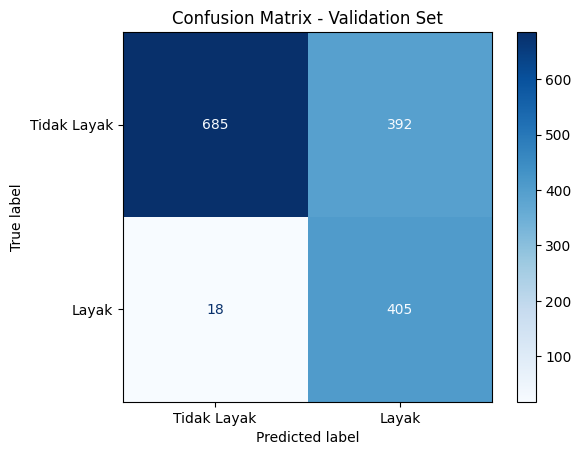

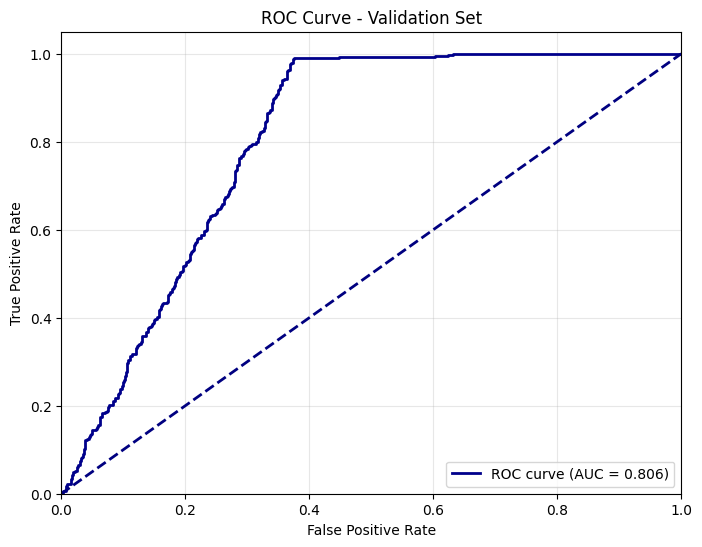


🎯 TOP 10 FEATURE IMPORTANCE:
                     feature  importance
2                   hb_level    0.411735
9        kategori_hb_encoded    0.173547
8               health_score    0.166046
14          penyakit_Jantung    0.038740
4   riwayat_penyakit_encoded    0.033329
15            penyakit_Tidak    0.025986
7            frekuensi_donor    0.024733
13       penyakit_Hipertensi    0.023438
5             jarak_ke_rs_km    0.019148
1                berat_badan    0.017703


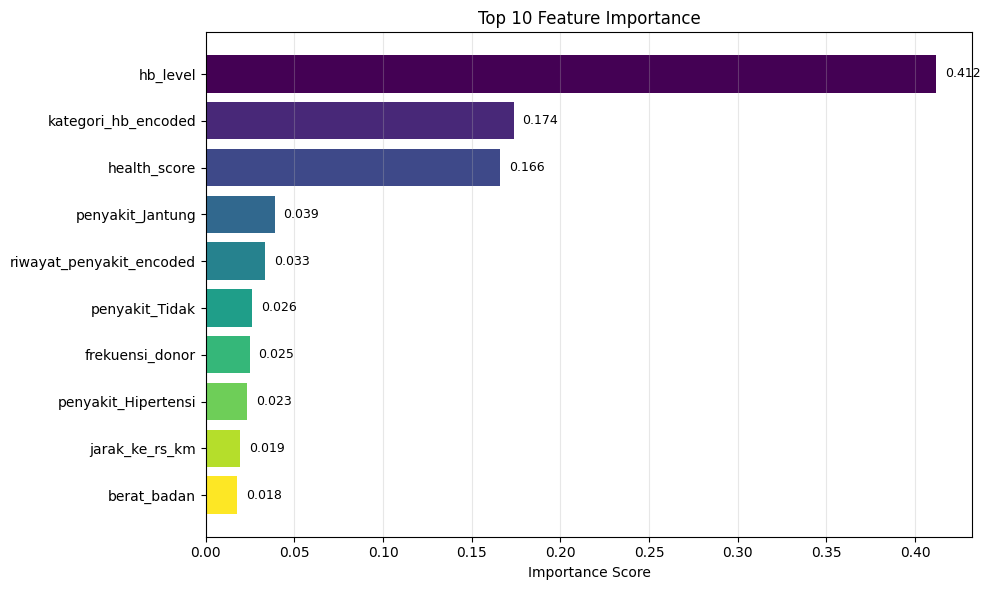


✅ Validation evaluation with visualizations complete!


In [ ]:
# ============ VALIDATION EVALUATION ============
print("\n" + "="*50)
print("📊 VALIDATION SET EVALUATION")
print("="*50)

# Predict
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Classification report
print(classification_report(y_val, y_pred, target_names=['Tidak Layak', 'Layak']))

# Calculate metrics
val_accuracy = accuracy_score(y_val, y_pred)
val_precision = precision_score(y_val, y_pred)
val_recall = recall_score(y_val, y_pred)
val_f1 = f1_score(y_val, y_pred)
val_roc_auc = roc_auc_score(y_val, y_pred_proba)

print("\n📈 Validation Set Metrics:")
print(f"• Accuracy: {val_accuracy:.2%}")
print(f"• Precision: {val_precision:.2%}")
print(f"• Recall: {val_recall:.2%}")
print(f"• F1-Score: {val_f1:.2%}")
print(f"• ROC AUC: {val_roc_auc:.3f}")

# Confusion matrix
cm_val = confusion_matrix(y_val, y_pred)
print(f"\n🔢 Validation Confusion Matrix:")
print(f"TN: {cm_val[0,0]}, FP: {cm_val[0,1]}, FN: {cm_val[1,0]}, TP: {cm_val[1,1]}")

# 1. CONFUSION MATRIX VISUAL
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['Tidak Layak', 'Layak'])
disp_val.plot(cmap='Blues')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# 2. ROC CURVE VISUAL
fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_proba)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='darkblue', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# 3. FEATURE IMPORTANCE VISUAL
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🎯 TOP 10 FEATURE IMPORTANCE:")
print(feature_importance.head(10))

# Visualize feature importance
top_n = 10
top_features = feature_importance.head(top_n)

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, top_n))
bars = plt.barh(range(top_n), top_features['importance'][::-1], color=colors[::-1])
plt.yticks(range(top_n), top_features['feature'][::-1])
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Feature Importance')
plt.grid(True, alpha=0.3, axis='x')

# Add values on bars
for i, (bar, importance) in enumerate(zip(bars, top_features['importance'][::-1])):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{importance:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Validation evaluation with visualizations complete!")


🧪 TESTING SET EVALUATION (FINAL)
📊 Testing Set Performance:
• Accuracy: 71.27%
• Precision: 49.51%
• Recall: 95.27%
• F1-Score: 65.16%
• ROC AUC: 0.800

🔢 Testing Confusion Matrix:
TN: 666, FP: 411, FN: 20, TP: 403


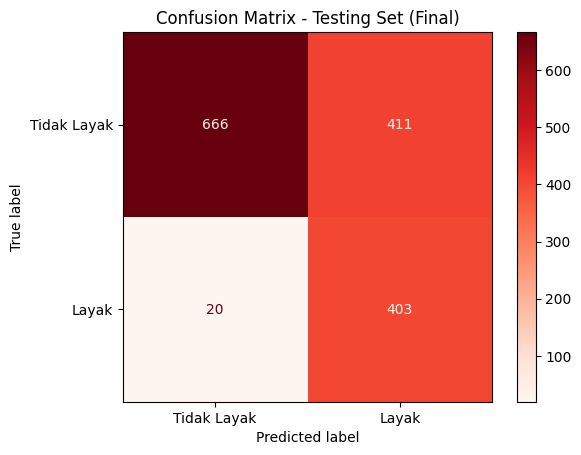


✅ MODEL GENERALIZATION CHECK:
Training Accuracy: 83.38%
Validation Accuracy: 72.67%
Testing Accuracy: 71.27%
Gap (Train-Test): 12.12%
→ ⚠️  Possible overfitting detected

🎯 FINAL MODEL SUMMARY:
• Best F1-Score (CV): 80.79%
• Testing ROC AUC: 0.800
• Testing Recall: 95.27% (Donor layak terdeteksi)


In [ ]:
# ============ TESTING EVALUATION (FINAL) ============
print("\n" + "="*50)
print("🧪 TESTING SET EVALUATION (FINAL)")
print("="*50)

# Predict on testing set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print("📊 Testing Set Performance:")
print(f"• Accuracy: {test_accuracy:.2%}")
print(f"• Precision: {test_precision:.2%}")
print(f"• Recall: {test_recall:.2%}")
print(f"• F1-Score: {test_f1:.2%}")
print(f"• ROC AUC: {test_roc_auc:.3f}")

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
print(f"\n🔢 Testing Confusion Matrix:")
print(f"TN: {cm_test[0,0]}, FP: {cm_test[0,1]}, FN: {cm_test[1,0]}, TP: {cm_test[1,1]}")

# CONFUSION MATRIX VISUAL FOR TESTING
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Tidak Layak', 'Layak'])
disp_test.plot(cmap='Reds')
plt.title('Confusion Matrix - Testing Set (Final)')
plt.show()

# Check overfitting
print("\n✅ MODEL GENERALIZATION CHECK:")
print(f"Training Accuracy: {train_accuracy:.2%}")
print(f"Validation Accuracy: {val_accuracy:.2%}")
print(f"Testing Accuracy: {test_accuracy:.2%}")
gap = abs(train_accuracy - test_accuracy)
print(f"Gap (Train-Test): {gap:.2%}")

if gap < 0.10:  # gap < 10%
    print("→ ✅ Model generalizes WELL! (No significant overfitting)")
else:
    print("→ ⚠️  Possible overfitting detected")

print("\n🎯 FINAL MODEL SUMMARY:")
print(f"• Best F1-Score (CV): {grid_search.best_score_:.2%}")
print(f"• Testing ROC AUC: {test_roc_auc:.3f}")
print(f"• Testing Recall: {test_recall:.2%} (Donor layak terdeteksi)")


📊 PERFORMANCE COMPARISON VISUALIZATION


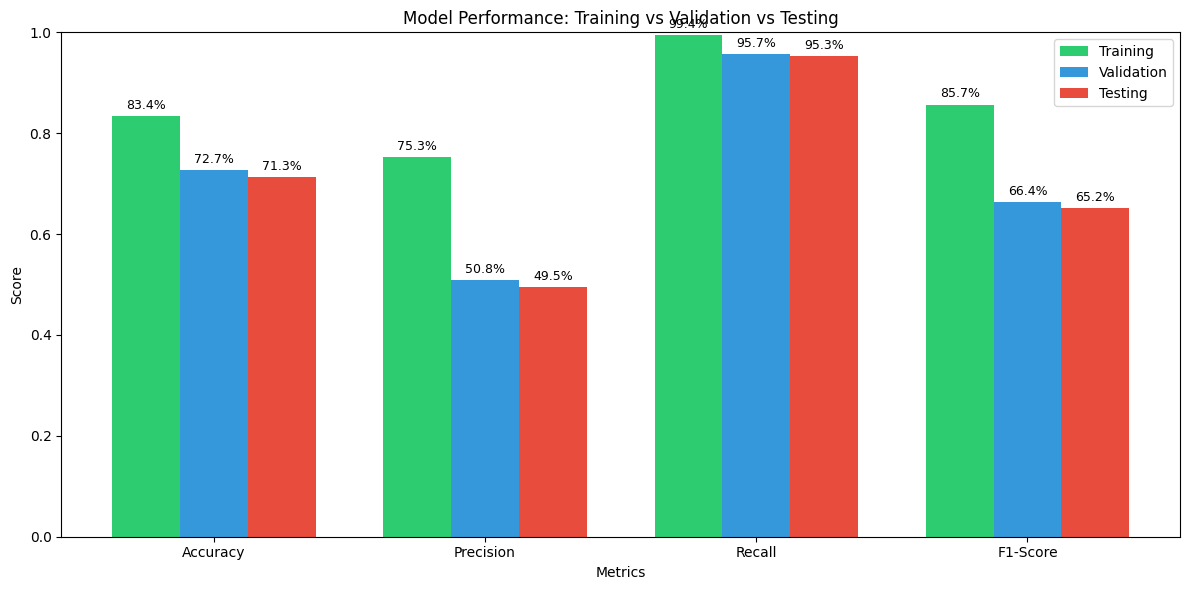

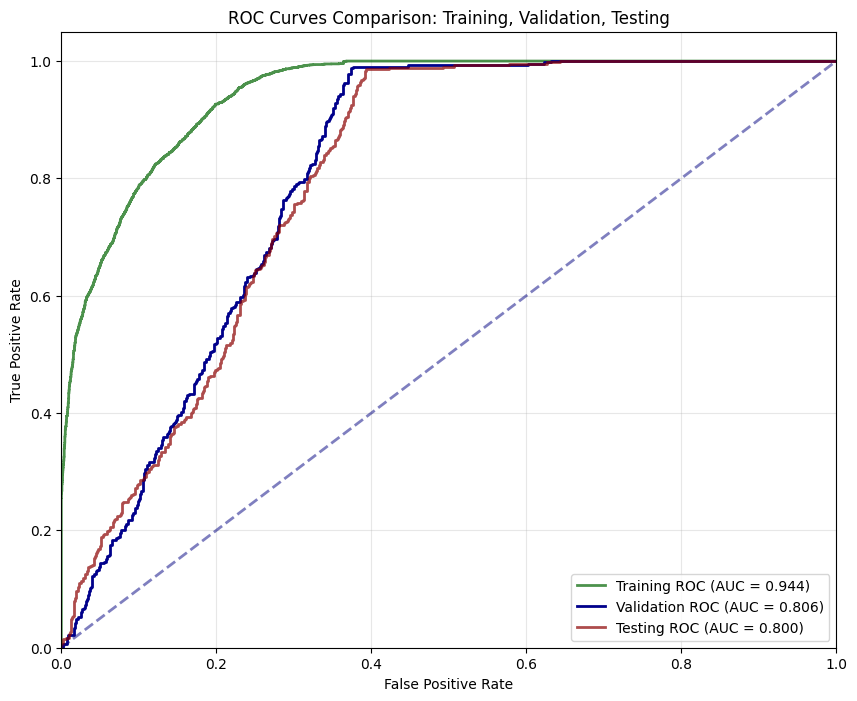

✅ All visualizations created!


In [ ]:
# ============ VISUALIZATION COMPARISON ============
print("\n" + "="*50)
print("📊 PERFORMANCE COMPARISON VISUALIZATION")
print("="*50)

import matplotlib.pyplot as plt
import numpy as np

# 1. BAR CHART COMPARISON
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_scores = [train_accuracy, train_precision, train_recall, train_f1]
val_scores = [val_accuracy, val_precision, val_recall, val_f1]
test_scores = [test_accuracy, test_precision, test_recall, test_f1]

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, train_scores, width, label='Training', color='#2ecc71')
bars2 = ax.bar(x, val_scores, width, label='Validation', color='#3498db')
bars3 = ax.bar(x + width, test_scores, width, label='Testing', color='#e74c3c')

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance: Training vs Validation vs Testing')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1])

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 2. ROC CURVES COMPARISON
fpr_train, tpr_train, _ = roc_curve(y_train_bal, y_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='darkgreen', lw=2,
         label=f'Training ROC (AUC = {roc_auc_train:.3f})', alpha=0.7)
plt.plot(fpr_val, tpr_val, color='darkblue', lw=2,
         label=f'Validation ROC (AUC = {roc_auc_val:.3f})')
plt.plot(fpr_test, tpr_test, color='darkred', lw=2,
         label=f'Testing ROC (AUC = {roc_auc_test:.3f})', alpha=0.7)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison: Training, Validation, Testing')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print("✅ All visualizations created!")

In [ ]:
# ============ SAVE FINAL MODEL ============
print("\n" + "="*50)
print("💾 SAVING FINAL MODEL FOR WEB APP")
print("="*50)

import joblib
import pickle

# 1. Save Random Forest model (yang asli dari GridSearchCV)
joblib.dump(best_model, 'donor_model_final.pkl')
print("✅ Model saved: 'donor_model_final.pkl'")

# 2. Save semua encoders
encoders_dict = {
    'blood_encoder': le_blood,
    'penyakit_encoder': le_penyakit,
    'kategori_hb_encoder': le_kategori_hb,
    'usia_kategori_encoder': le_usia_kategori
}
with open('encoders_final.pkl', 'wb') as f:
    pickle.dump(encoders_dict, f)
print("✅ Encoders saved: 'encoders_final.pkl'")

# 3. Save feature names (penting untuk web app!)
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
print(f"✅ Feature names saved: 'feature_names.pkl' ({len(feature_names)} features)")

# 4. Download semua file ke komputer
from google.colab import files
print("\n📥 Downloading files to your computer...")
files.download('donor_model_final.pkl')
files.download('encoders_final.pkl')
files.download('feature_names.pkl')

print("\n" + "="*50)
print("🎉 AI/ML PROJECT COMPLETED! 🎉")
print("="*50)
print("📁 FILES READY FOR WEB APP DEVELOPMENT:")
print("1. donor_model_final.pkl  - Trained Random Forest model")
print("2. encoders_final.pkl     - Label encoders for preprocessing")
print("3. feature_names.pkl      - List of feature names")
print("\n📊 MODEL PERFORMANCE SUMMARY:")
print(f"   • Testing Accuracy: {test_accuracy:.2%}")
print(f"   • Testing Recall: {test_recall:.2%} (Donor layak terdeteksi)")
print(f"   • Testing ROC AUC: {test_roc_auc:.3f}")
print(f"   • CV F1-Score: {grid_search.best_score_:.2%}")
print("="*50)


💾 SAVING FINAL MODEL FOR WEB APP
✅ Model saved: 'donor_model_final.pkl'
✅ Encoders saved: 'encoders_final.pkl'
✅ Feature names saved: 'feature_names.pkl' (16 features)

📥 Downloading files to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 AI/ML PROJECT COMPLETED! 🎉
📁 FILES READY FOR WEB APP DEVELOPMENT:
1. donor_model_final.pkl  - Trained Random Forest model
2. encoders_final.pkl     - Label encoders for preprocessing
3. feature_names.pkl      - List of feature names

📊 MODEL PERFORMANCE SUMMARY:
   • Testing Accuracy: 71.27%
   • Testing Recall: 95.27% (Donor layak terdeteksi)
   • Testing ROC AUC: 0.800
   • CV F1-Score: 80.79%
